<a href="https://colab.research.google.com/github/dathrika13/cs666student/blob/main/CS666_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

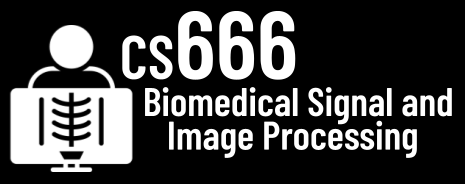
# Assignment 6

In [ ]:
# NAME: SAICHARITHA DATHRIKA

In [ ]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [ ]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# We will use mahotas as well!

!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: mahotas is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussio

In [ ]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-24 22:20:01--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz’

mito.npz            100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-24 22:20:05 (367 MB/s) - ‘mito.npz’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [ ]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

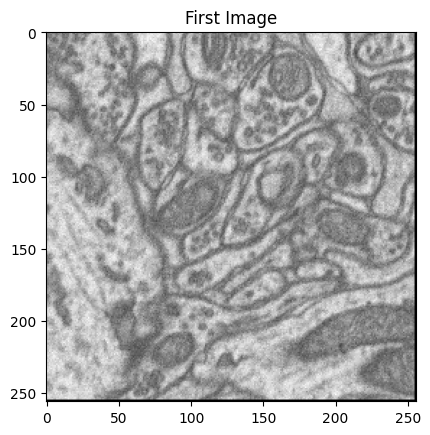

In [ ]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE

import matplotlib.pyplot as plt

# Get the first image
img = images[0]

# Display the image with gray colormap
plt.imshow(img, cmap='gray')
plt.title('First Image')
plt.show()


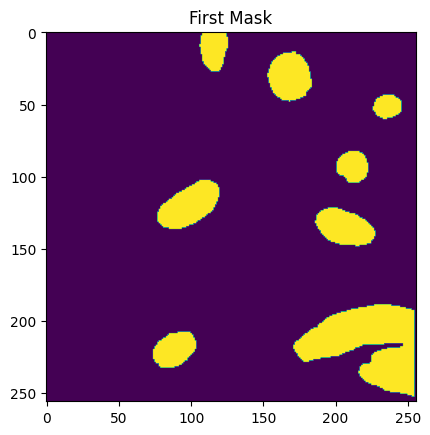

In [ ]:
# TODO: Show the first mask.

# Get the first mask
mask = masks[0]

# Display the mask
plt.imshow(mask)
plt.title('First Mask')
plt.show()

## 1. SAM in AUTO mode (15 points)

In [ ]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
# !pip install metaseg

!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.9 MB/s eta 0:00:00
  Created wheel for metaseg: filename=metaseg-0.6.1-py3-none-any.whl size=44772 sha256=d8a5b3cacb34917805ca8d877691f68701a569886999df814c376d22ee274b37
  Stored in directory: /root/.cache/pip/wheels/b1/0c/bd/5e8d8f9aa755ac2f82e75b9391db0d403f760a4654b19c8b6c
Successfully built meta

In [ ]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [ ]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [ ]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model has been successfully downloaded and saved as 'vit_l.pth'.


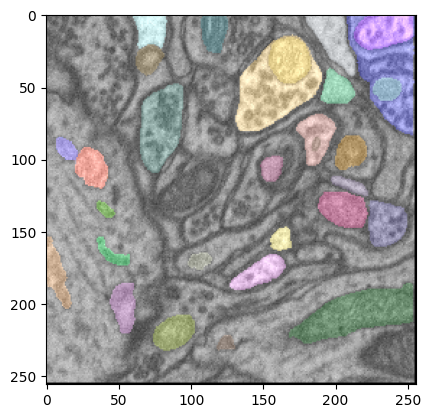

In [ ]:
imshow( mh.imread('first_output.png') )

In [ ]:
# TODO: Does SAM work well for mitochondria detection?

It can be seen that it worked well.
but in the right upper most corner it didn't detect exact mitochondria but better I guess.

Also the output detected image is not exactly same as the training mask used.


In [ ]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

vit_l model already exists as 'vit_l.pth'. Skipping download.


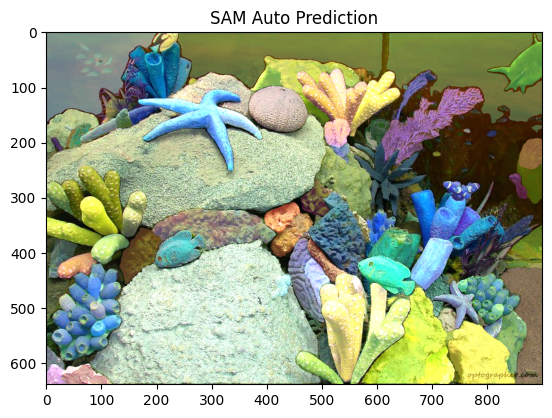

In [ ]:
# TODO: YOUR CODE

# Load your own image
img = mh.imread('img.jpg')

# Save the image as a PNG file
mh.imsave('img.jpg', img)

# Run SAM in auto mode on your image and store the result as second_output.png
results = SegAutoMaskPredictor().image_predict(
    source="img.jpg",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)

# Display the output
plt.imshow(mh.imread('second_output.png'))
plt.title('SAM Auto Prediction')
plt.show()


In [ ]:
# TODO: Does SAM work well on your example?
# TODO: it worked perfectly well

## 2. Train a U-Net classifier from scratch (50 points)


In [ ]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


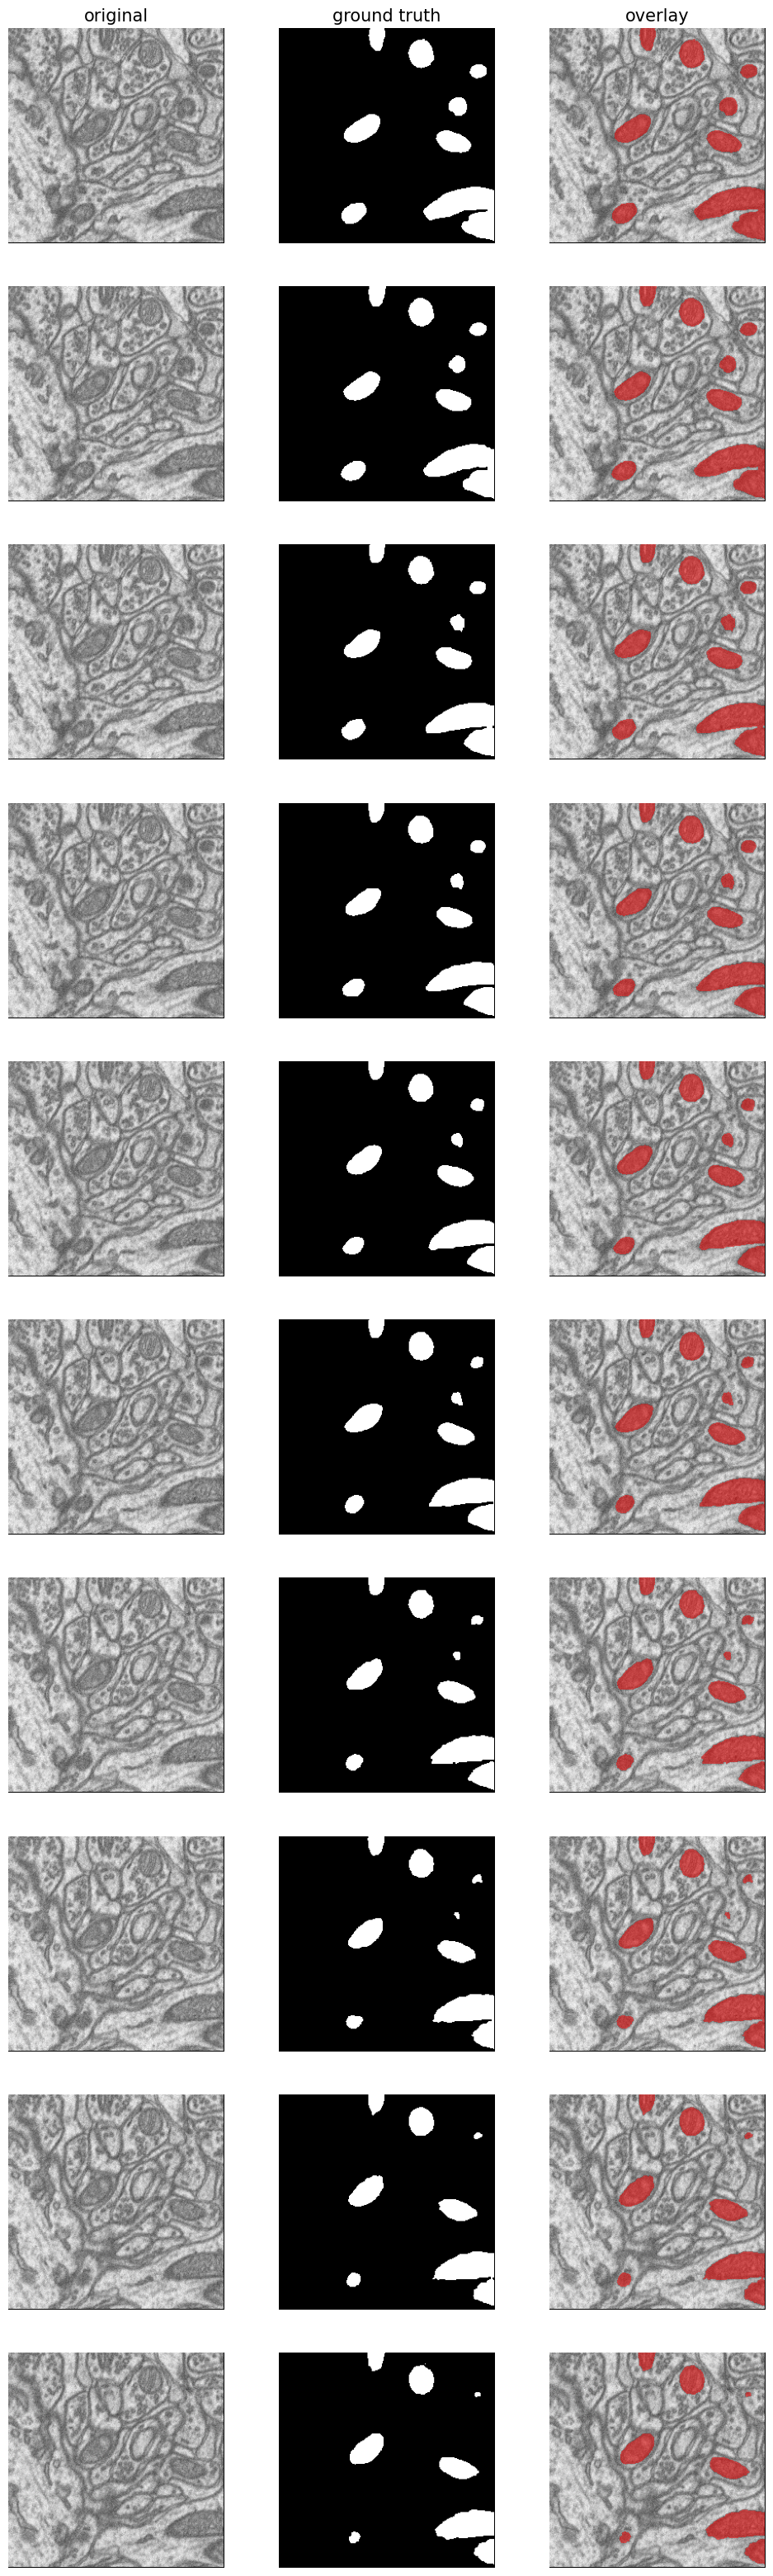

In [ ]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [ ]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
X = images.astype('float32') / images.max()

# Add the last channel using reshape
X = X.reshape(X.shape + (1,))


In [ ]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [ ]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: 
# Convert to bool
y = masks.astype(bool)

# Add the last channel using reshape
y = y.reshape(y.shape + (1,))


In [ ]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [ ]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [ ]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [ ]:
# TODO: Why do we call train_test_split twice?

The first call to train_test_split splits the data into training and testing sets, while the second call to train_test_split splits the training set further into training and validation sets.
So we call train_test_split twice to split the data into three sets: training, validation, and testing.

This is to make sure that the model generalizes well to new data.

In [ ]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [ ]:
# TODO: Please explain the code from above.


- the code creates a data generator for the training data using the get_augmented function from the keras_unet.utils module.
- it performs data agumentation on input images and masks.
it takes the training data X_train and y_train as input, along with the batch_size parameter.
- The data_gen_args parameter defines various data augmentation techniques such as rotations, shifts, shears, zooms, and flips to be applied to input images and masks during training.
- we used the fill_mode parameter to specify how to fill empty pixels resulting from data augmentation and train a neural network using the resulting generator with Keras' fit_generator function.

(2, 256, 256, 1) (2, 256, 256, 1)


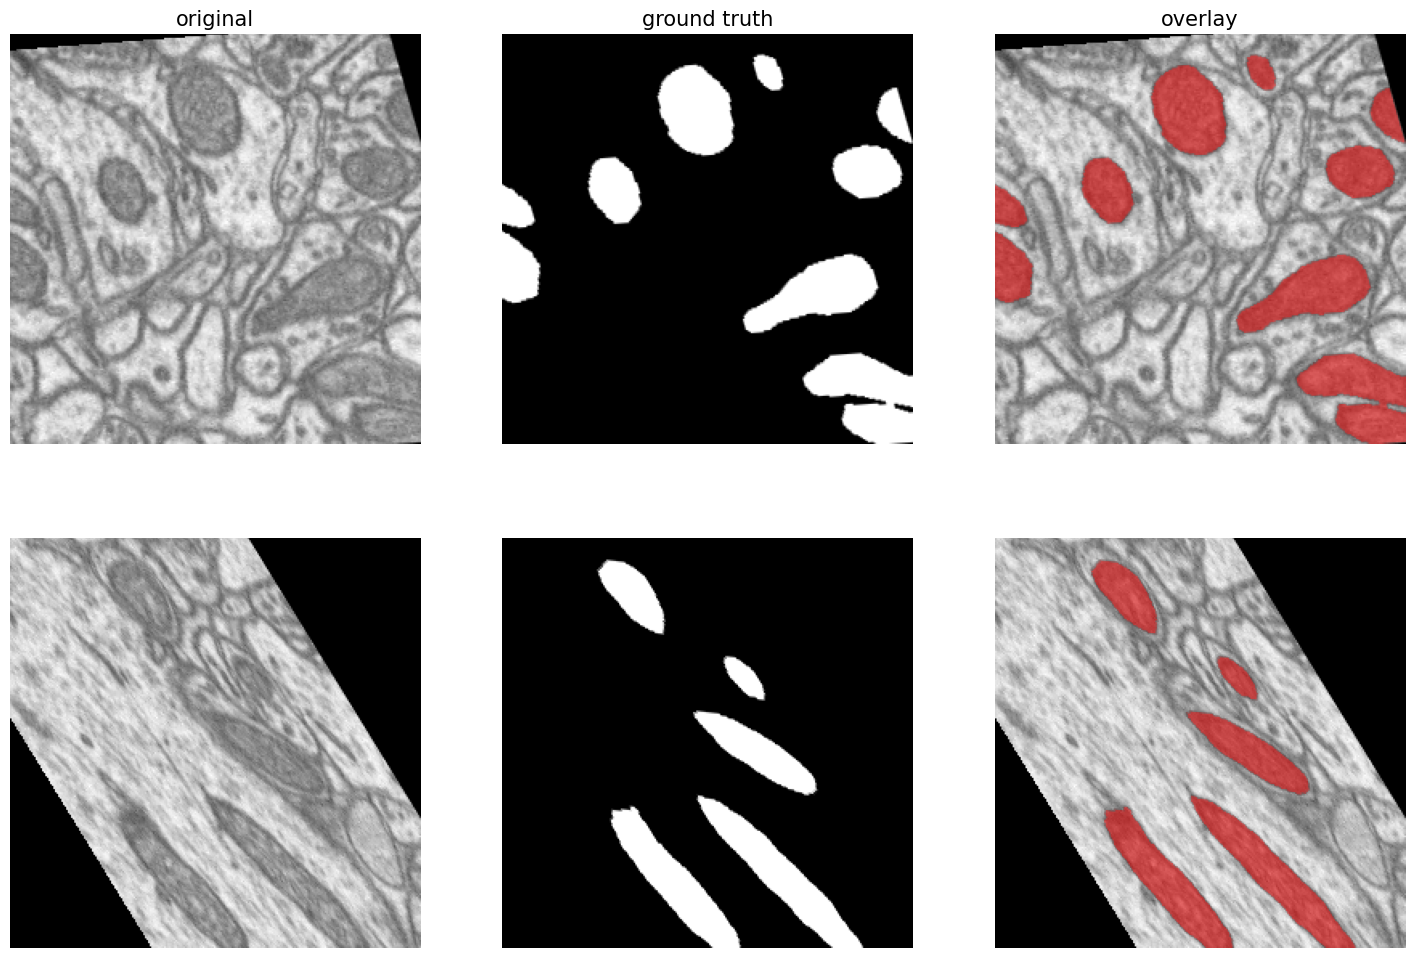

In [ ]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [ ]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [ ]:
# TODO: How many  trainable parameters does the model use?

model.summary()
# Trainable parameters used in the model are 31,030,593 parameters.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [ ]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [ ]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.


- Intersect-over-Union (IoU) is used in image segmentation.
- it caluculates the intersection ratio of predicted and truth masks. 
- if the ratio is 1 it indicated perfect overlap and if it is 0 indicates no overlap.
- so it provides a single value that summarizes the performance of the model across all possible thresholds.

In [ ]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train),
    validation_data=(X_val, y_val),
    epochs=30
)

Epoch 1/30
369/369 [==============================] - 109s 273ms/step - loss: 0.2085 - iou: 0.0983 - iou_thresholded: 0.0359 - val_loss: 0.2768 - val_iou: 0.0909 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 58s 157ms/step - loss: 0.1752 - iou: 0.1308 - iou_thresholded: 0.0272 - val_loss: 0.1599 - val_iou: 0.1883 - val_iou_thresholded: 0.0020
Epoch 3/30
369/369 [==============================] - 56s 153ms/step - loss: 0.1308 - iou: 0.2470 - iou_thresholded: 0.2556 - val_loss: 0.1462 - val_iou: 0.2808 - val_iou_thresholded: 0.5023
Epoch 4/30
369/369 [==============================] - 57s 153ms/step - loss: 0.1277 - iou: 0.2442 - iou_thresholded: 0.2796 - val_loss: 0.1052 - val_iou: 0.3589 - val_iou_thresholded: 0.5252
Epoch 5/30
369/369 [==============================] - 56s 152ms/step - loss: 0.0953 - iou: 0.3899 - iou_thresholded: 0.5060 - val_loss: 0.0670 - val_iou: 0.6402 - val_iou_thresholded: 0.7030
Epoch 6/30
369/369 [====================

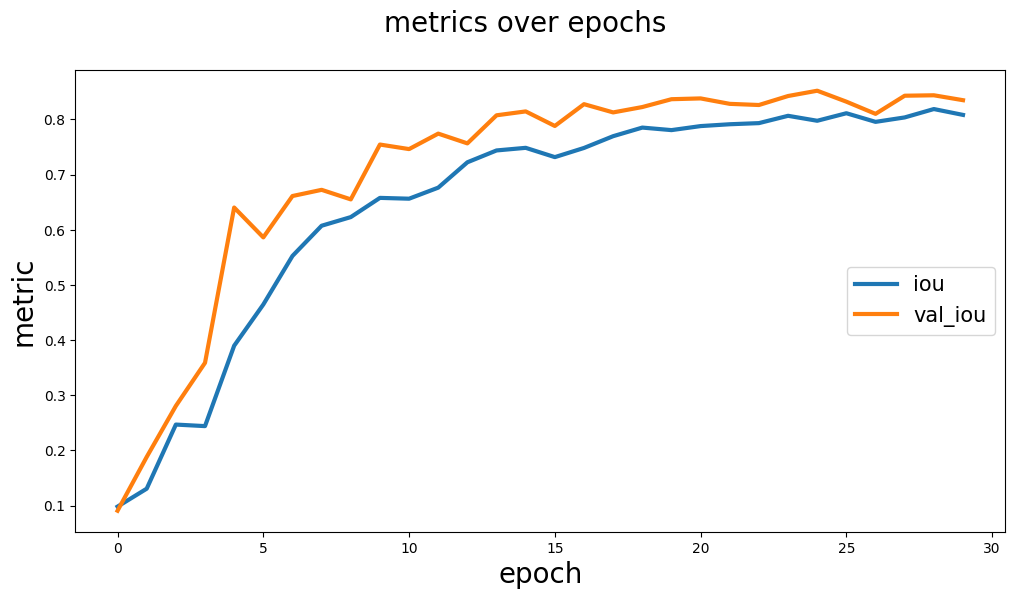

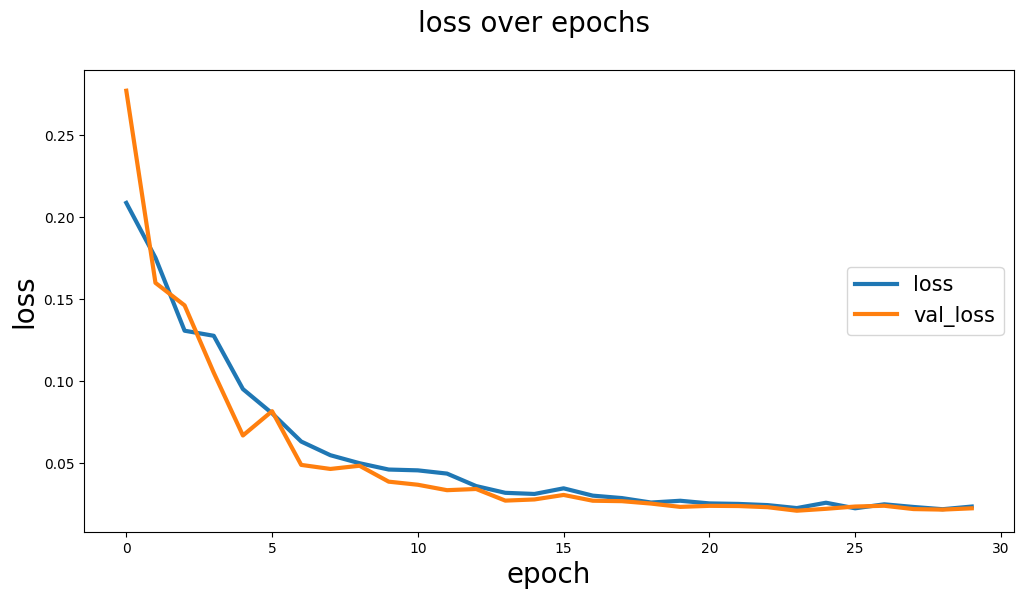

In [ ]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [ ]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

By the above plots we can observe that the training loss and validation losss are decreasing over time, which is good.
The training and validation IoU scores are also same.
However, it appears that the validation IoU score is lower than the training IoU score, indicating that the model may be overfitting to the training data.

## 3. Evaluate U-Net (10 points)

In [ ]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 1s/step


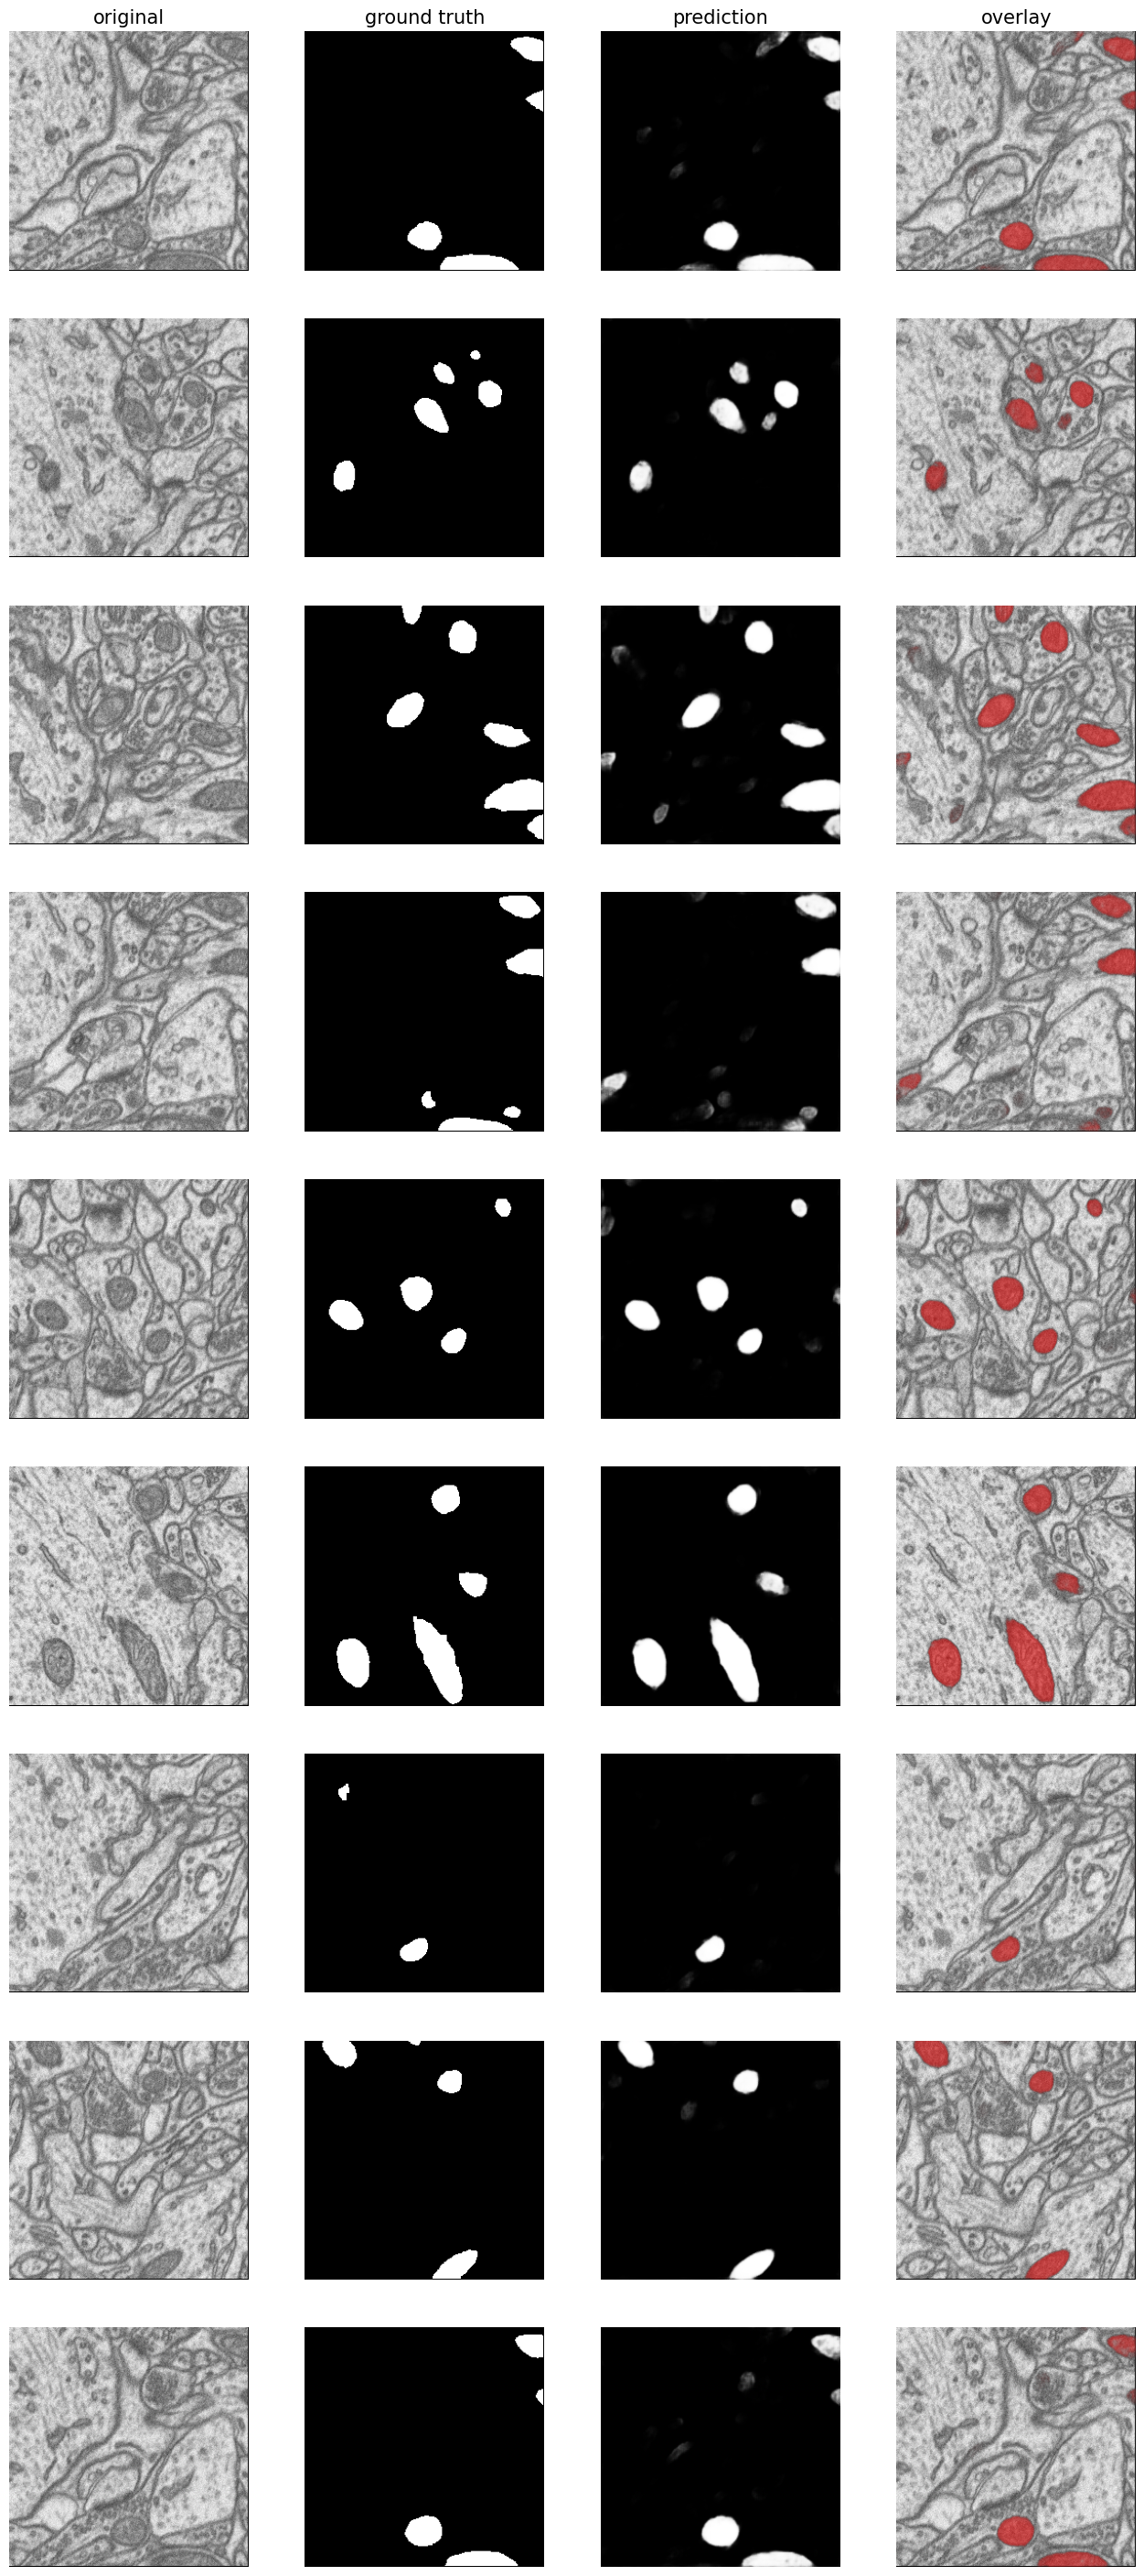

In [ ]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [ ]:
import sklearn.metrics

In [ ]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8924198720874333

In [ ]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 

- both of them evaluate similarity between two sets, but differ in how they calculate this similarity.
- The Jaccard score measures the similarity of two sets by the intersection of their sizes divided by the union, when the predicted mask is thresholded.
- but the IoU measures the ratio of the intersection between predicted and ground truth masks to their union.

In [ ]:
# TODO: Did the U-Net perform well on X_test?

it seems that the U-Net was able to accurately segment the objects of interest. The Jaccard score also indicates a reasonable overlap between the predicted and true masks.
so yeah it performed well.

## 4. Combine U-Net with SAM (10 points)

In [ ]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [ ]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [ ]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [ ]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [ ]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: saves the image img as a test.png
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: creates a predicated mask by applying 0.5 as threshold 
  # for the U-net prediction
  pred = (y_pred[z] > 0.5)

  # TODO: assigns a unique integer label to each connected component of the mask.
  # returns pred as labeled image
  pred, _ = mh.labeled.label(pred)
  
  # TODO: compute bounding boxes from the labeled mask
  bbs = mh.labeled.bbox(pred)

  # TODO: The bounding boxes are converted from mahotas format to SAM format 
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: use the SAM model to predict masks inside each bounding box
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: The resulting SAM segmentation mask is converted to a binary 
  # mask by taking the union of all labeled regions.
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: combines U-Net predition with SAM. the resulting 
  #binary image is stored in y_pred_sam.
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [ ]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8924198720874333

In [ ]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8633520820588357

In [ ]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# U-Net + Sam addition doesnot seem to be a good addition. 
# U-Net alone is able to perform better without the addition. 

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  pred = (y_pred[z] > 0.9)
 
  pred, _ = mh.labeled.label(pred)
  
  bbs = mh.labeled.bbox(pred)

  bbs_converted = mahotas_bbox_to_sam(bbs) 

  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  sam_and_unet_pred = sam_to_mask(results)
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

  # Improved U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())


vit_l model already exists as 'vit_l.pth'. Skipping download.


In [ ]:
#references: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

#collaborated with manasa-01

# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#